In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
test=pd.read_csv('test_table.csv.txt')
user=pd.read_csv('user_table.csv.txt')

In [4]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [5]:
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [25]:
#Merge the two datasets
data=pd.merge(test,user,on='user_id')

In [7]:
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico


## 1. Checking whether the test was actually negative

For checking that, we need to prove that every country other than spain performed better in the control group(no changes) than when in test group(after changes).

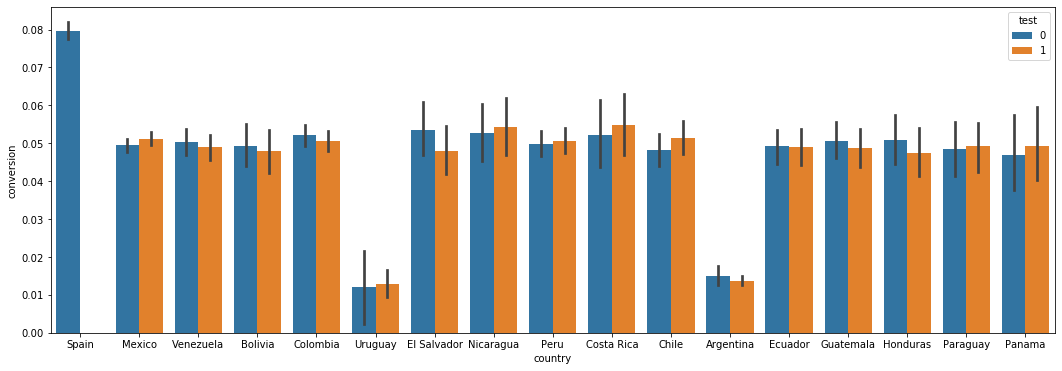

In [44]:
# Visualization 
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='country', y='conversion', hue='test', data=data, ax=ax)
plt.show()

In [46]:
# A/B test
from scipy.stats import ttest_ind
test_data = data[data['country'] != 'Spain']
test_val = test_data[test_data['test'] == 1]['conversion'].values
cont_val = test_data[test_data['test'] == 0]['conversion'].values
# Welch Two Sample t-test
print(ttest_ind(test_val, cont_val, equal_var=False))

Ttest_indResult(statistic=-7.353895203080277, pvalue=1.9289178577799033e-13)


We can observe that for most countries, control group performs better than the test group hence confirming that the test was indeed negative. 

## 2] Are the localized translations really worse?

Checking randomization
Checking that randomization worked well simply means making sure that all variables have the same distribution in test and control. 

In [13]:
#source variable
data_grouped_by_source=data.groupby('source')['test'].agg({"test_group":lambda x : len(x[x==1]),"control_group":lambda x: len(x[x==0])})

C:\Users\sarva\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [14]:
print(data_grouped_by_source/data_grouped_by_source.sum())

        test_group  control_group
source                           
Ads       0.400641       0.401720
Direct    0.199500       0.201149
SEO       0.399858       0.397131


As we can see, relative frequency of source for different segments is the same. That is, we have basically the same proportion of users coming from Ads, Direct, and SEO in both test and control.
 
We could keep checking all the variables like this. But it would be extremely time consuming.
 

So, implementing a decision tree algorithm would help!!
 
Use the variable test as our label. Try to build a model that manages to separate the users whose test value is 0 vs those whose test value is 1. If randomization worked well, this will be impossible because the two groups are exactly the same. If all variable relative frequencies were the same as for source, no model would be able to separate test == 1 vs test == 0. If randomization did not work well, the model will manage to use a given variable to separate the two groups.
 

The decision tree will allow us to clearly see which variable (if any) is used for the split. That’s where randomization failed.

In [18]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source

In [26]:
data=data.drop(['user_id'],axis=1)
data_dummy = pd.get_dummies(data)
train_cols=data_dummy.drop(['test','conversion'],axis=1)
tree=DecisionTreeClassifier(class_weight='balanced',min_impurity_decrease = 0.001)
tree.fit(train_cols,data_dummy['test'])

In [38]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Users\sarva\Anaconda3\Library\bin\graphviz"
export_graphviz(tree, out_file="tree_testing.dot", feature_names=train_cols.columns, proportion=True, rotate=True)
with open("tree_testing.dot") as f:
    dot_graph = f.read()
s = Source.from_file("tree_testing.dot")
s.view()

'tree_testing.dot.pdf'

On viewing the decision tree formed, we can see that when country spain is 1 (False branch), all samples lie in the control group as expected. This is obvious as there were no changes made in the translation for spain. However, when the country is argentina, only 18.6% people are in the control group and 81.4% are in the test group. Similary, for uruguay, 0.09% are in control group whereas 90.8% are in the test group. This shows a skew in the data towards the test group and indicates that there was an error during the randomization process.
From this we can conclude that localized translation did not make things worse as the test performed was biased!